# Сравнительная оценка игровых моделей для оценки и визуализации взаимодействий между нейронами в нейронной сети прямого распространения

## Введение

В этом блокноте рассматриваются визуализации игровых моделей полносвязной нейронной сети. Параметры нейронной сети регулируются в ячейке `#::Setup`.

Мы просимулируем три варианта обучения:
1. Без модификаций
2. С полным дропаутом
3. С градиентным дропаутом

и посмотрим, что происходит с равновесием Нэша в каждом из случаев.

Решаем на примере предсказания функции $\mathrm{TARGET\_FUNCTION}(x, y) = sin(x + y)$.



In [25]:
#::Setup

import math

NETWORK_CONFIGURATION = [2, 4, 4, 1]

def TARGET_FUNCTION(x: float, y: float) -> float:
    return math.sin(x + y)

[NETWORK_INPUTS, *HIDDEN_LAYERS, NETWORK_OUTPUTS] = NETWORK_CONFIGURATION

N_SAMPLES = 500
"Количество точек для обучения."

NOISE_LEVEL = 0.05
"Уровень шума в данных."

EPOCHS = 2000
"Количество эпох обучения."

LEARNING_RATE = 0.01
"Скорость обучения."

DROPOUT_PROBABILITY = 0.3
"Вероятность для обоих видов дропаута."

print(f"Inputs count: {NETWORK_INPUTS}")
print(f"Hidden layers: {HIDDEN_LAYERS}")
print(f"Outputs count: {NETWORK_OUTPUTS}")

Inputs count: 2
Hidden layers: [4, 4]
Outputs count: 1


## Вид целевой функции

Форма обучающих данных X: torch.Size([500, 2])
Форма обучающих данных y: torch.Size([500, 1])


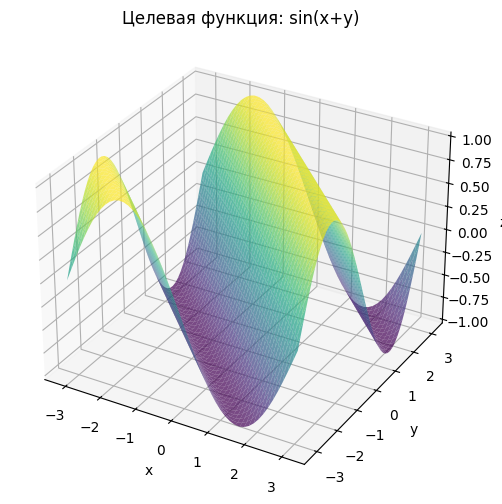

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# --- Генерация данных ---
X = np.random.uniform(-np.pi, np.pi, (N_SAMPLES, 2))
y = np.sin(X[:, 0] + X[:, 1]) + np.random.normal(0, NOISE_LEVEL, N_SAMPLES)

# Конвертация в тензоры PyTorch
X_train = torch.FloatTensor(X)
y_train = torch.FloatTensor(y).view(-1, 1)

print(f"Форма обучающих данных X: {X_train.shape}")
print(f"Форма обучающих данных y: {y_train.shape}")


# --- Визуализация исходной функции для сравнения ---
def plot_true_function(ax):
    """Отрисовывает идеальную функцию sin(x+y)"""
    x_space = np.linspace(-np.pi, np.pi, 50)
    y_space = np.linspace(-np.pi, np.pi, 50)
    X_grid, Y_grid = np.meshgrid(x_space, y_space)
    Z_grid = np.sin(X_grid + Y_grid)
    ax.plot_surface(X_grid, Y_grid, Z_grid,
                    cmap="viridis", alpha=0.7,
                    label="True Function")
    ax.set_title("Целевая функция: sin(x+y)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
plot_true_function(ax)
plt.show()

## Реализация моделей

In [3]:
class GradientDropoutFunction(torch.autograd.Function):
    """
    Градиентный дропаут. Отключает часть нейронов на обратном
    распространении ошибки.
    
    На прямом проходе нейроны остаются активными.
    """
    @staticmethod
    def forward(ctx, input, p=0.5, training=False):
        # В режиме forward pass ничего не делаем, просто передаем данные дальше
        # Сохраняем p и training для backward pass
        ctx.p = p
        ctx.training = training
        return input

    @staticmethod
    def backward(ctx, grad_output):
        # В режиме backward pass применяем маску к градиенту
        if ctx.training:
            p = ctx.p
            # Создаем маску Бернулли
            mask = (torch.rand(grad_output.shape) < p).to(grad_output.device)
            # Применяем маску к градиенту и нормализуем, чтобы сохранить масштаб
            # В отличие от обычного дропаута, здесь мы можем не нормализовывать,
            # так как это просто "шум" в обучении. Но для сравнения сделаем.
            return grad_output * mask / p, None, None
        else:
            return grad_output, None, None

class GradientDropout(nn.Module):
    """
    Обертка для удобного использования градиентного дропаута
    в `nn.Sequential`.
    """
    def __init__(self, p=0.5):
        super(GradientDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, but got {}".format(p))
        self.p = p

    def forward(self, input):
        return GradientDropoutFunction.apply(input, self.p, self.training)


class FFNN(nn.Module):
    """
    Архитектура нейронной сети.
    """
    def __init__(self, config, mode="base", p=0.5):
        super(FFNN, self).__init__()
        
        layers = []
        input_dim = config[0]
        
        for i, units in enumerate(config[1:-1]):
            layers.append(nn.Linear(input_dim, units))
            
            if mode == "dropout":
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p))
            elif mode == "gradient_dropout":
                layers.append(nn.ReLU())
                layers.append(GradientDropout(p))
            elif mode == "base":
                layers.append(nn.ReLU())
            else:
                raise ValueError(f"Mode {mode} is not supported.")
            
            input_dim = units
            
        layers.append(nn.Linear(input_dim, config[-1]))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# --- Инициализация трех моделей для сравнения ---

base_model = FFNN(NETWORK_CONFIGURATION, mode="base")
dropout_model = FFNN(NETWORK_CONFIGURATION, mode="dropout", p=DROPOUT_PROBABILITY)
# Для GradientDropout мы хотим, чтобы p была вероятностью СОХРАНЕНИЯ градиента
# p_keep = 1.0 - DROPOUT_PROBABILITY
gradient_dropout_model = FFNN(NETWORK_CONFIGURATION, mode="gradient_dropout", p=(1.0 - DROPOUT_PROBABILITY))

print("--- Базовая модель ---")
print(base_model)
print("\n--- Модель с Dropout ---")
print(dropout_model)
print("\n--- Модель с Gradient Dropout ---")
print(gradient_dropout_model)

--- Базовая модель ---
FFNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)

--- Модель с Dropout ---
FFNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=4, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

--- Модель с Gradient Dropout ---
FFNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): GradientDropout()
    (3): Linear(in_features=4, out_features=4, bias=True)
    (4): ReLU()
    (5): GradientDropout()
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)


# Обучение и визуализация



--- Финальные результаты всех экспериментов ---


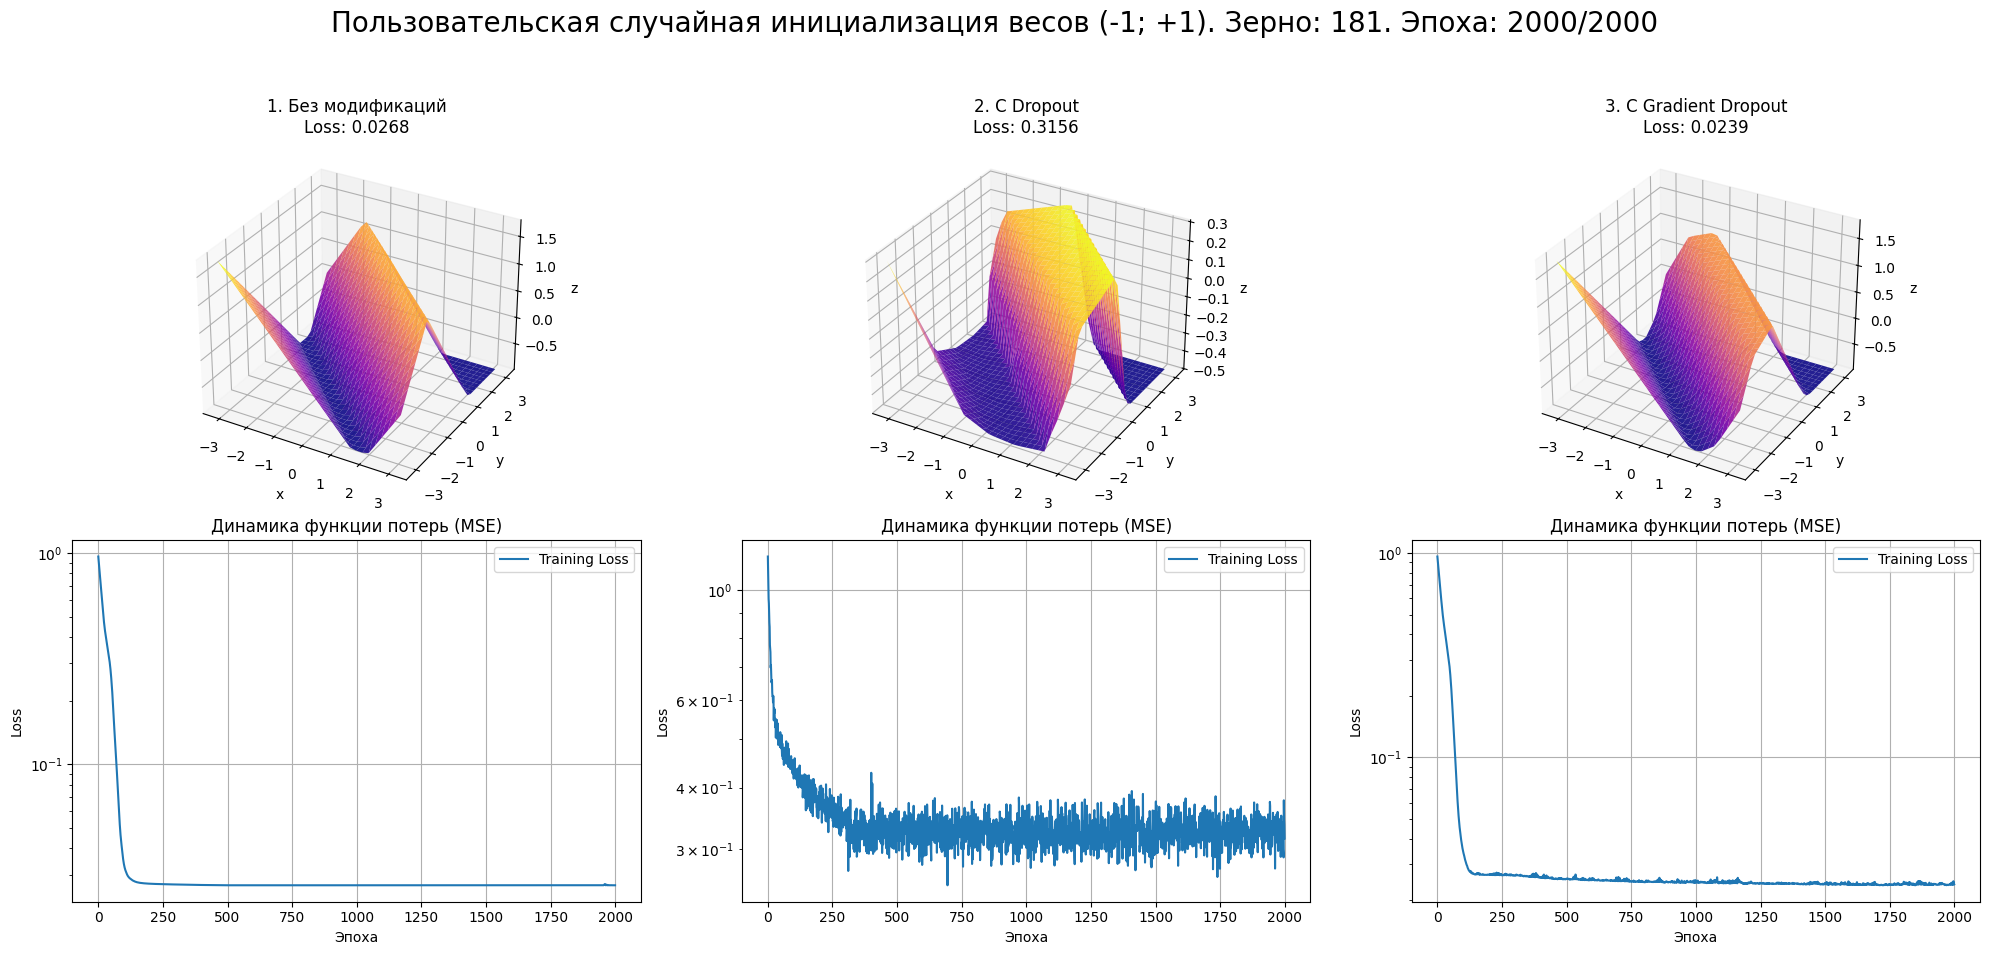

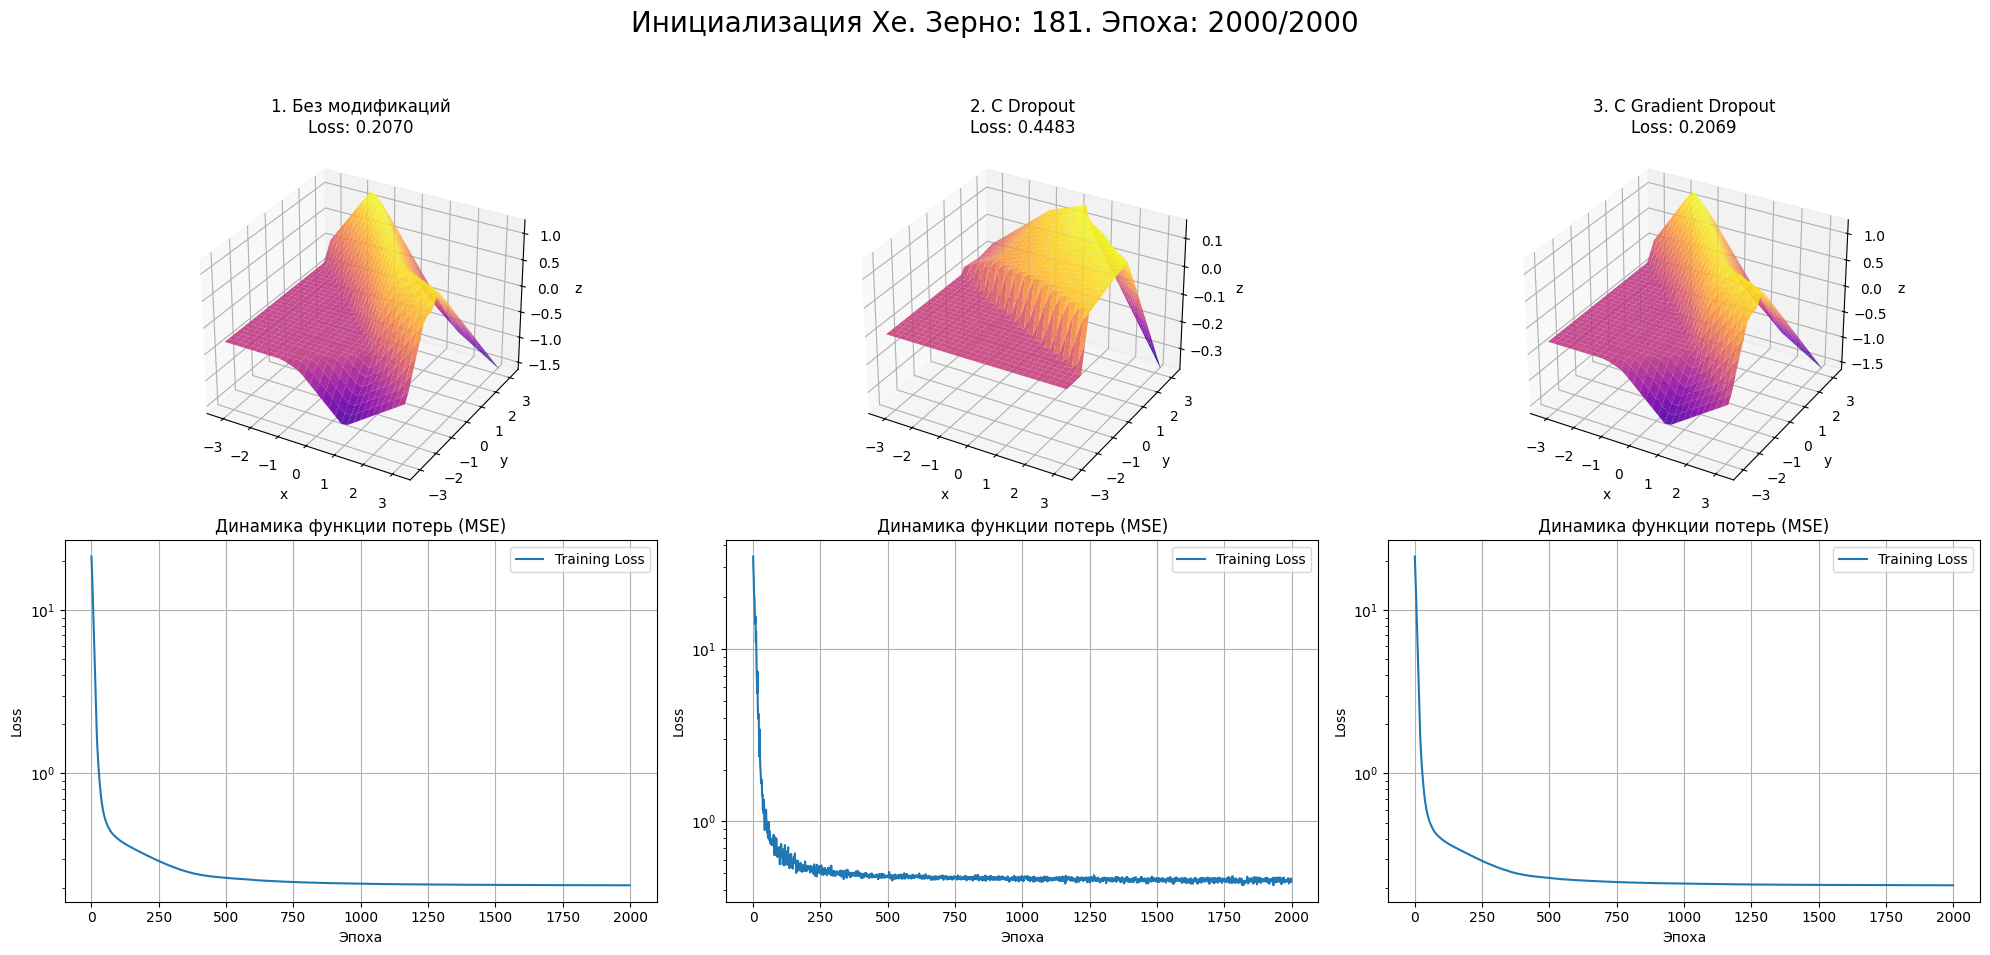


Все эксперименты завершены и результаты отображены.


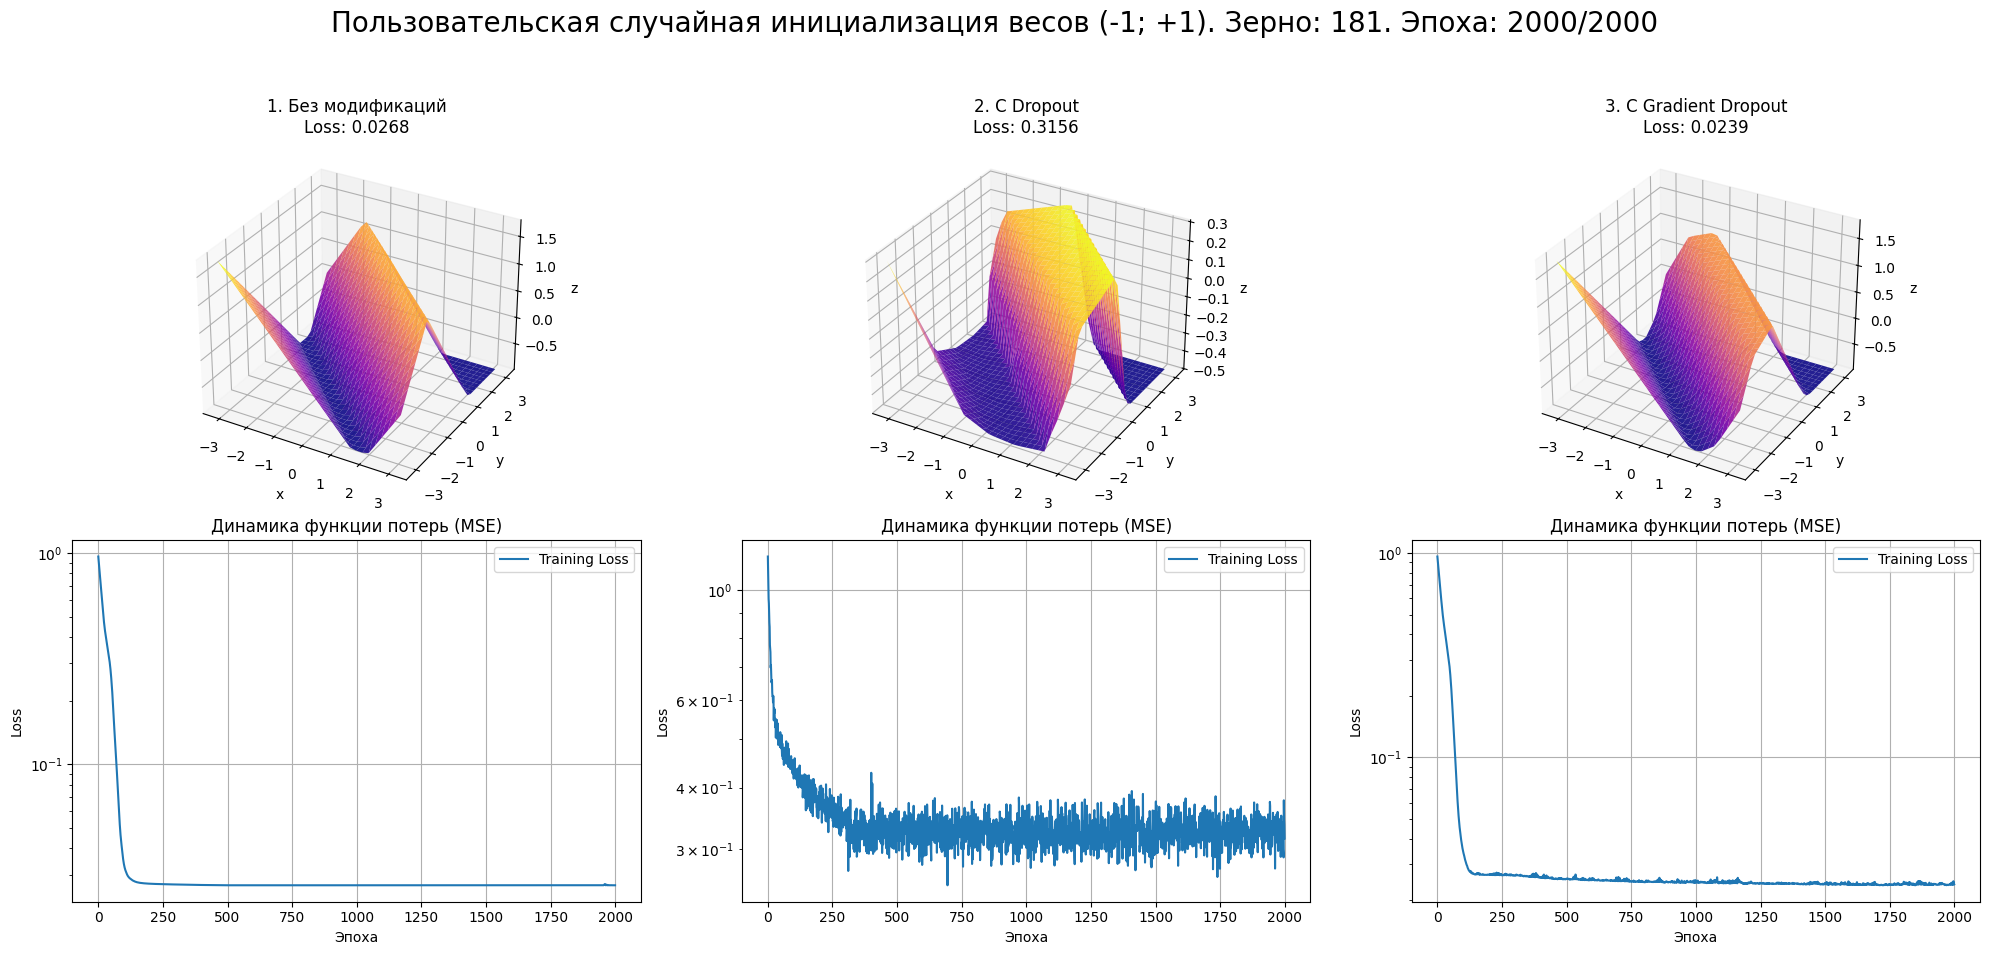

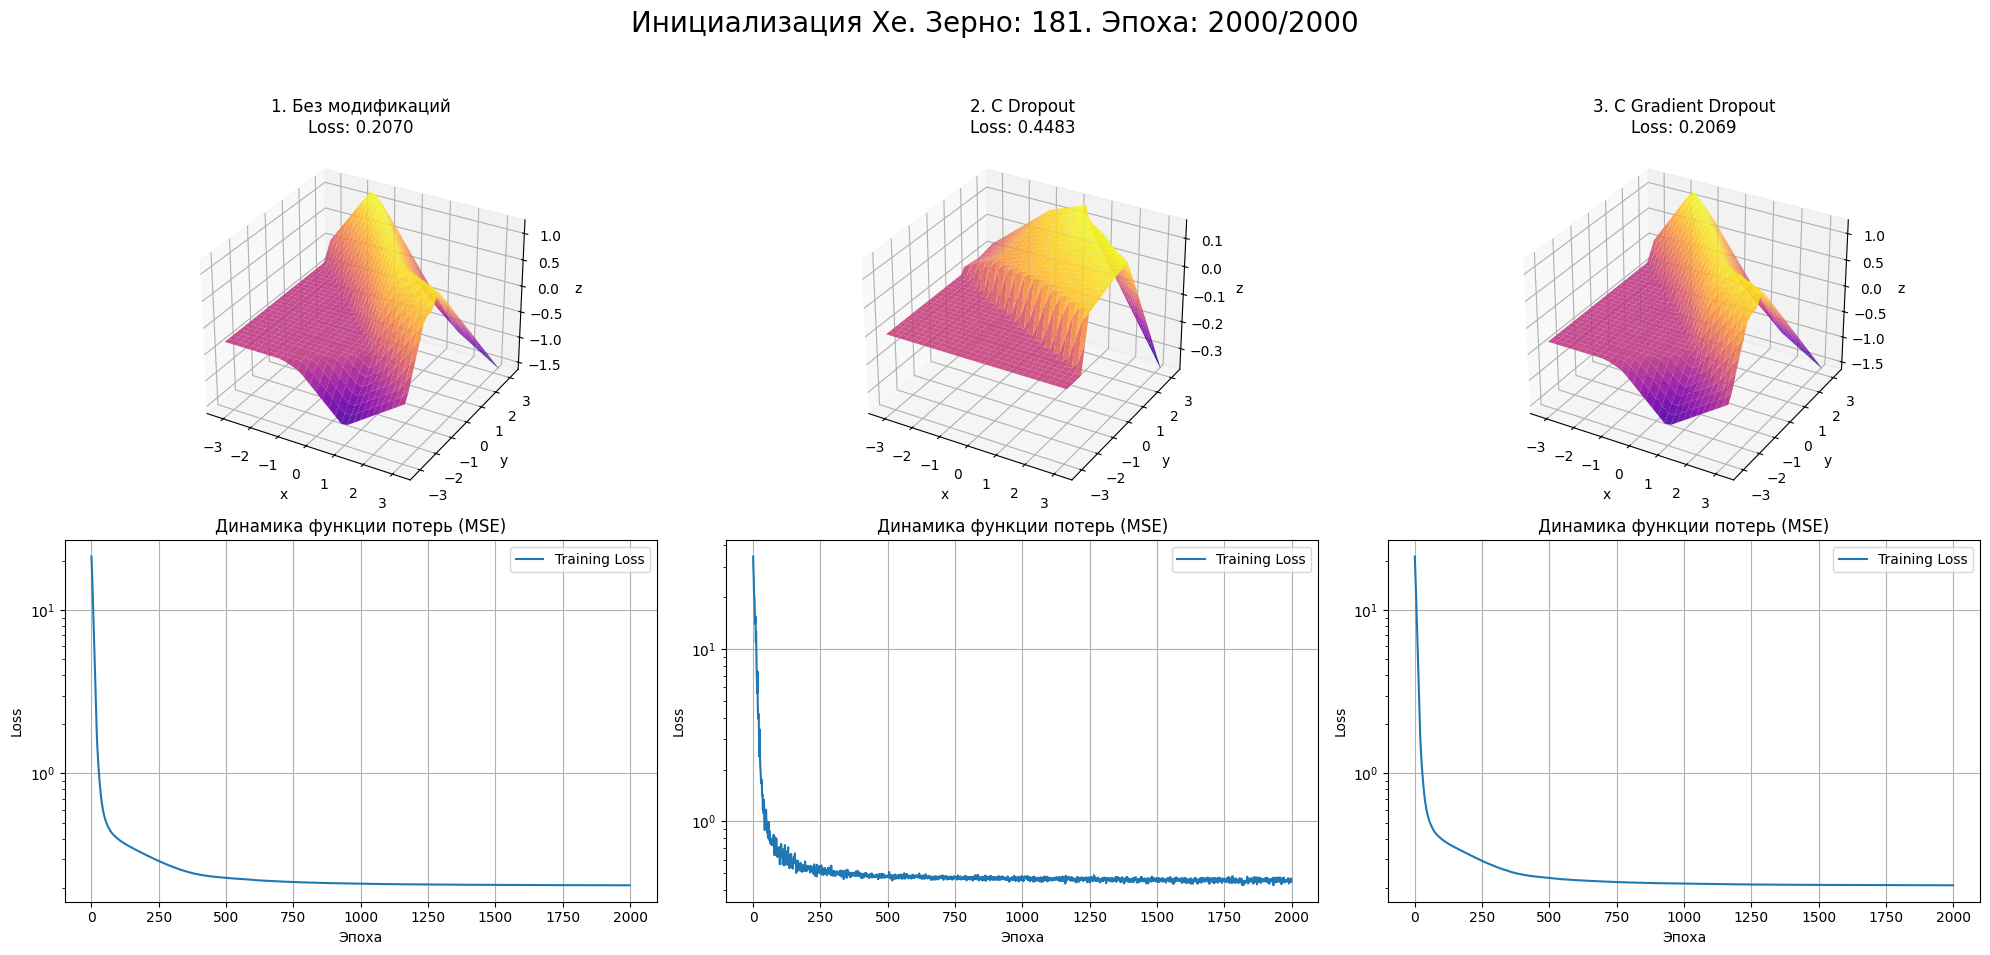

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def init_weights_he(m):
    """Применяет инициализацию весов Хе (Kaiming) к линейным слоям."""
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def init_weights_custom_random(m):
    """Применяет случайную инициализацию весов в диапазоне (-1; +1) к линейным слоям."""
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, -1.0, 1.0)
        if m.bias is not None:
            nn.init.uniform_(m.bias, -1.0, 1.0) # Инициализируем смещения тоже в этом диапазоне


def run_experiment(initialization_type, seed, main_title):
    """
    Проводит полный цикл эксперимента: инициализация, обучение и визуализация.
    Возвращает финальный объект Figure.
    
    Args:
        initialization_type (str): Тип инициализации ('random' или 'he').
        seed (int): Зерно для воспроизводимости.
        main_title (str): Основной заголовок для графиков.
    
    Returns:
        matplotlib.figure.Figure: Объект фигуры с финальными графиками обученной модели.
    """
    print(f"\n{'='*50}")
    print(f"НАЧАЛО ЭКСПЕРИМЕНТА: {main_title}")
    print(f"{'='*50}\n")
    
    # 1. Фиксируем зерно для полной воспроизводимости данного прогона
    torch.manual_seed(seed)
    np.random.seed(seed)

    # 2. Создаем "свежие" модели для каждого эксперимента
    base_model = FFNN(NETWORK_CONFIGURATION, mode='base')
    dropout_model = FFNN(NETWORK_CONFIGURATION, mode='dropout', p=DROPOUT_PROBABILITY)
    gradient_dropout_model = FFNN(NETWORK_CONFIGURATION, mode='gradient_dropout', p=(1.0 - DROPOUT_PROBABILITY))

    # 3. Применяем выбранный тип инициализации и копируем веса
    if initialization_type == 'he':
        print("Применяется инициализация Хе (Kaiming)...")
        base_model.apply(init_weights_he)
    elif initialization_type == 'random':
        print("Применяется пользовательская случайная инициализация (-1; +1)...")
        # --- ИЗМЕНЕНИЕ ЗДЕСЬ ---
        base_model.apply(init_weights_custom_random)
        # ---------------------
    
    # Копируем веса из базовой модели в другие, чтобы обеспечить ИДЕНТИЧНЫЙ старт
    with torch.no_grad():
        base_linear = [m for m in base_model.modules() if isinstance(m, nn.Linear)]
        
        target_linear_dp = [m for m in dropout_model.modules() if isinstance(m, nn.Linear)]
        for base_l, target_l in zip(base_linear, target_linear_dp):
            target_l.weight.copy_(base_l.weight)
            target_l.bias.copy_(base_l.bias)
            
        target_linear_gdp = [m for m in gradient_dropout_model.modules() if isinstance(m, nn.Linear)]
        for base_l, target_l in zip(base_linear, target_linear_gdp):
            target_l.weight.copy_(base_l.weight)
            target_l.bias.copy_(base_l.bias)
            
    print("Веса всех моделей синхронизированы для идентичного старта.\n")

    # 4. Подготовка к обучению
    models = [base_model, dropout_model, gradient_dropout_model]
    titles = ["1. Без модификаций", "2. С Dropout", "3. С Gradient Dropout"]
    optimizers = [torch.optim.Adam(m.parameters(), lr=LEARNING_RATE) for m in models]
    loss_fn = nn.MSELoss()
    all_losses = [[], [], []]

    # 5. Основной цикл обучения и визуализации
    fig = plt.figure(figsize=(20, 10))
    axes_3d = [fig.add_subplot(2, 3, i+1, projection='3d') for i in range(3)]
    axes_2d = [fig.add_subplot(2, 3, i+4) for i in range(3)]

    for epoch in range(EPOCHS):
        for i, model in enumerate(models):
            model.train()
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            all_losses[i].append(loss.item())
            optimizers[i].zero_grad()
            loss.backward()
            optimizers[i].step()

        if (epoch + 1) % 100 == 0:
            clear_output(wait=True) # Очищаем вывод перед каждой новой порцией графиков
            fig.suptitle(f"{main_title}. Эпоха: {epoch + 1}/{EPOCHS}", fontsize=20)
            
            for i, model in enumerate(models):
                model.eval() # Переключаем в режим оценки
                
                # Визуализация 3D поверхности
                ax_3d = axes_3d[i]
                ax_3d.clear()
                x_space = np.linspace(-np.pi, np.pi, 30)
                y_space = np.linspace(-np.pi, np.pi, 30)
                X_grid, Y_grid = np.meshgrid(x_space, y_space)
                with torch.no_grad():
                    xy_pairs = torch.FloatTensor(np.c_[X_grid.ravel(), Y_grid.ravel()])
                    Z_pred = model(xy_pairs).numpy().reshape(X_grid.shape)
                ax_3d.plot_surface(X_grid, Y_grid, Z_pred, cmap="plasma", alpha=0.9)
                ax_3d.set_title(f"{titles[i]}\nLoss: {all_losses[i][-1]:.4f}")
                ax_3d.set_xlabel("x"); ax_3d.set_ylabel("y"); ax_3d.set_zlabel("z")
                
                # Визуализация графика потерь
                ax_2d = axes_2d[i]
                ax_2d.clear()
                ax_2d.plot(all_losses[i], label="Training Loss")
                ax_2d.set_title("Динамика функции потерь (MSE)")
                ax_2d.set_xlabel("Эпоха"); ax_2d.set_ylabel("Loss")
                ax_2d.set_yscale("log"); ax_2d.legend(); ax_2d.grid(True)
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            display(fig) # Отображаем текущую фигуру (не закрываем ее)
            
    print(f"\nЗАВЕРШЕНИЕ ЭКСПЕРИМЕНТА: {main_title}")
    return fig # Возвращаем финальную фигу


SEED = 181

final_experiment_figures = []
# "Список для хранения финальных фигур"

# --- Прогон 1: Случайная (стандартная) инициализация ---
print("\n--- Запуск эксперимента со случайной инициализацией ---")
fig_random_init = run_experiment(
    initialization_type='random', 
    seed=SEED,
    main_title=f"Инициализация равномерно распределёнными случайными весами (-1; +1). Зерно: {SEED}"
)
final_experiment_figures.append(fig_random_init)

# Небольшая пауза между экспериментами
time.sleep(5) 

# --- Прогон 2: Инициализация Хе (Kaiming) ---
print("\n--- Запуск эксперимента с инициализацией He (Kaiming) ---")
fig_he_init = run_experiment(
    initialization_type='he', 
    seed=SEED,
    main_title=f"Инициализация Хе. Зерно: {SEED}"
)
final_experiment_figures.append(fig_he_init)


# -------------------------------------------------------------------
# --- ШАГ 7: ОТОБРАЖЕНИЕ ВСЕХ ФИНАЛЬНЫХ РЕЗУЛЬТАТОВ              ---
# -------------------------------------------------------------------
clear_output(wait=True) # Очищаем экран в конце, чтобы показать только финальные результаты

print("\n\n--- Финальные результаты всех экспериментов ---")
for i, fig_to_display in enumerate(final_experiment_figures):
    if i > 0:
        print("\n\n" + "="*80 + "\n\n") # Разделитель между разными экспериментами
    display(fig_to_display)
    # Если вы хотите, чтобы фигуры были "закрыты" после отображения
    # и не занимали память в блокноте, можно добавить plt.close(fig_to_display)
    # plt.close(fig_to_display) 

print("\nВсе эксперименты завершены и результаты отображены.")